# Bayesian Multilevel Modelling using PyStan

This is a tutorial, following through Chris Fonnesbeck's [primer on using PyStan with Bayesian Multilevel Modelling](http://mc-stan.org/documentation/case-studies/radon.html).

# 12. Contextual Effects

In [1]:
%pylab inline

import numpy as np
import pandas as pd
import pystan
import seaborn as sns

import clean_data

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


/Users/lpritc/Development/GitHub/Teaching/Teaching-Stan-Hierarchical-Modelling/venv-Teaching-Stan-Hierarchical/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


## Contextual Effects

*Contextual effects* are a major confounder and arise when two or more unique sources of variance are combined into one source of variance for the model, and treated as if they are homogeneous (when they are not). For example, considering a relationship between individuals' stress and eating habits, there are at least two unique sources of variance for an individual's stress:

* inter-personal variance: person A may be generally more stressed than person B
* intra-personal variance: person A may be, *when measured*, more stressed than they are at other times

Combining both of these sources of variance into one explanatory variable is an example of *contextual effect*.

### A contextual effect in our model

It may be the case that there is a confounding relationship between the prevailing level of radon in a county, and the tendency to construct buildings that do, or do not, have a basement. As the presence of a basement means that radon is measured in the basement, and the absence of a basement means it is measured on the ground floor, in our study, we have access to this information.

In our data, the floor measurement is coded as `0` for basement and `1` for ground floor. So, for a county, the proportion of buildings with no basement can be represented by the mean floor coding, which we name $\bar{x}$.

With this variable, we can modify the relationship between estimated county-level radon and the county-level uranium measurement (as described in `11-group_level_predictors.ipynb`, to include $\bar{x}$ as a representative of this confounder:

$$\alpha_{j} = \gamma_0 + \gamma_1 u_j + \gamma_2 \bar{x} + \zeta_j$$

### Specifying the model

We define the model in `stan`, as usual specifying `data`, `parameters`, `transformed parameters` and `model` blocks. The model is built up as follows.

Our observed log(radon) measurements ($y$) approximate an intermediate transformed parameter $\hat{y}$, which is normally distributed with variance $\sigma_y^2$ (we leave the estimation of $\sigma_y^2$ to `Stan`'s defaults - this is not encouraged by `Stan`'s authors, as the defaults may change between versions!).

$$y \sim N(\hat{y}, \sigma_y^2)$$

The transformed variable $\hat{y}$ is a linear function of: $x_i$, the floor at which radon is measured; $u_i$, the uranium level in the county; and $\bar{x}_i$, the mean of floor measurement for each county. The parameters are: the intercept $\alpha_{j[i]}$, drawn from a Normal distribution with mean $\mu_{\alpha}$ and variance $\sigma_{\alpha}^2$; the effect due to county uranium level, $\beta_1$; and the effect due to county mean floor, $\beta_2$ (we again leave estimation of $\sigma_{\alpha}^2$ to `Stan`'s defaults)

$$\hat{y_i} = \alpha_{j[i]} + \beta_1 u_i + \beta_2 x_i + \beta_3 \bar{x}_i$$

The transformed variable $m_i$ is a linear function of . . The mean $\mu_{\alpha}$ is Normally distributed with mean 0 and unit variance.

$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\mu_{\alpha} \sim N(0, 1)$$

The values of $\beta_1$, $\beta_2$ and $\beta_3$ are Normally distributed with mean $0$ and variance $1$. 

$$\beta_1 \sim N(0, 1)$$
$$\beta_2 \sim N(0, 1)$$
$$\beta_3 \sim N(0, 1)$$

We first have to create our new variable to describe $\bar{x}$, which we do as `xbar`:

In [2]:
# Create new variable for mean of floor across counties
xbar = clean_data.srrs_mn.groupby('county')['floor'].mean().rename(clean_data.county_lookup).values
x_mean = xbar[clean_data.county]  # by household

In `data`:
* `J` is the number of counties (`int`)
* `N` is the number of samples (`int`)
* `county` is a list of `N` values from 1-85, specifying the county index each measurement
* `u` is a `vector` of uranium levels, in each county
* `x` is a `vector` of indices for which floor the radon measurements were taken at each household
* `x_mean` is a `vector` describing the average county floor for each household
* `y` is a `vector` of log(radon) measurements, one per household/sample.

We define parameters:

* `a` (`vector`, one value per county), representing $\alpha_j[i]$, the county-level intercept for the relationship of county radon level to county uranium level.
* `mu_a`, a `real` corresponding to $\mu_{\alpha}$, the mean radon level underlying the distribution from which the county levels are drawn.
* `sigma_a` is $\sigma_{\alpha}$, the standard deviation of the radon level distribution underlying the county levels: variability of county means about the average.
* `b` (`vector`, two values), representing: $\beta_1$, the slope of the relationship between county-level uranium and radon level; and $\beta_2$, the slope of the relationship between floor measurement and radon level.
* `sigma_y` is $\sigma_y$, the standard deviation of the measurement/sampling error: residual error of the observations.

In [3]:
contextual_effect = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> county[N];
  vector[N] u;
  vector[N] x;
  vector[N] x_mean;
  vector[N] y;
} 
parameters {
  vector[J] a;
  vector[3] b;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] <- a[county[i]] + u[i]*b[1] + x[i]*b[2] + x_mean[i]*b[3];
}
model {
  mu_a ~ normal(0, 1);
  a ~ normal(mu_a, sigma_a);
  b ~ normal(0, 1);
  y ~ normal(y_hat, sigma_y);
}
"""

### Fitting the model

Again, we map Python variables to those in the model, and run the fit:

In [4]:
n_county = clean_data.srrs_mn.groupby('county')['idnum'].count()  # number of samples from each county

contextual_effect_data = {'N': len(clean_data.log_radon),
                          'J': len(n_county),
                          'county': clean_data.county+1, # Stan counts starting at 1
                          'u': clean_data.u,
                          'x_mean': x_mean,
                          'x': clean_data.floor_measure,
                          'y': clean_data.log_radon}

contextual_effect_fit = pystan.stan(model_code=contextual_effect,
                                    data=contextual_effect_data, 
                                    iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b7928e9396770558600f70afccda0012 NOW.


We then extract estimates of the mean for $\beta_1$, $\beta_2$, $\beta_3$:

In [5]:
b_means = contextual_effect_fit['b'].mean(0)
b_1 = contextual_effect_fit['b'][:, 0]
b_2 = contextual_effect_fit['b'][:, 1]
b_3 = contextual_effect_fit['b'][:, 2]

## Interpreting the model output

We're interested here primarily in the value of $\beta_2$ as this will tell us what confidence we should have in whether there is a non-zero effect of the type of construction in the county: whether houses tend to have basements or not.

We can plot the distributions of parameters:

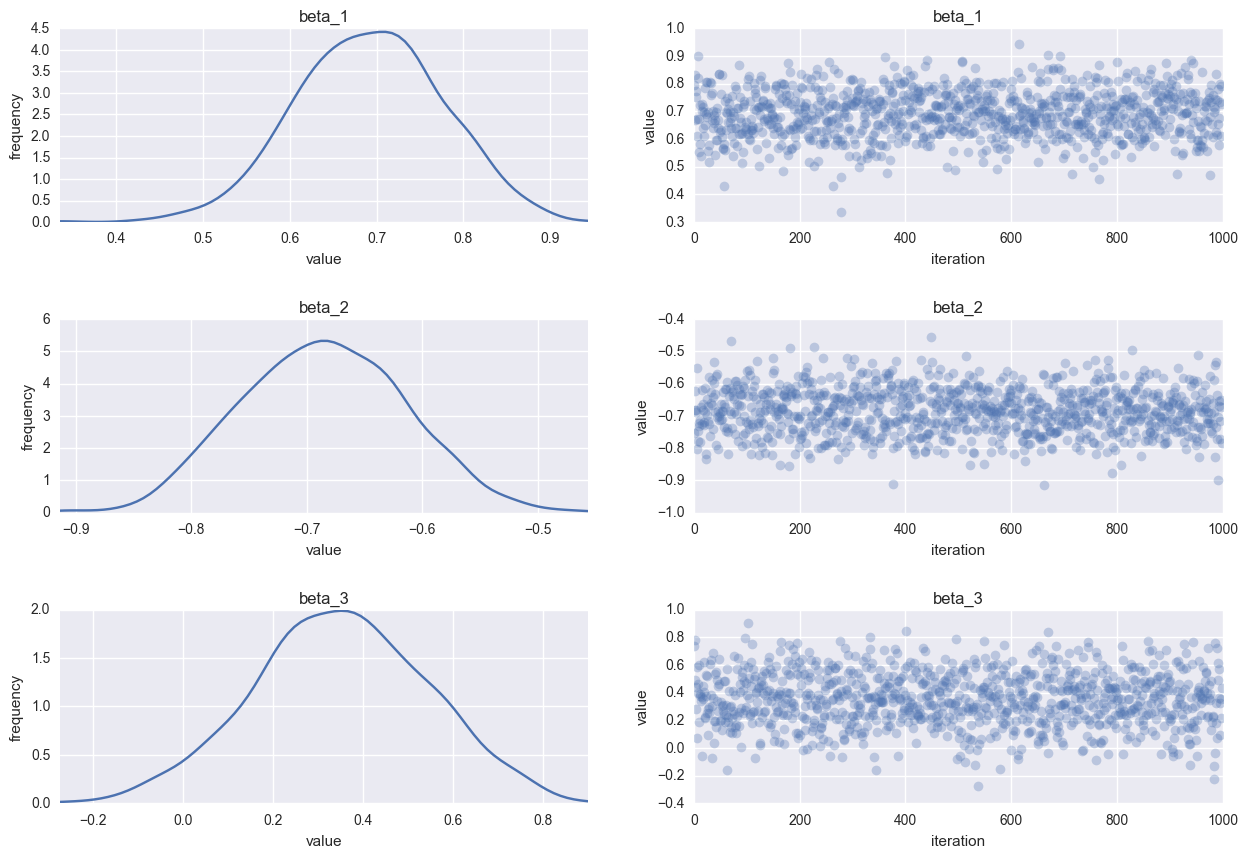

In [6]:
# 3x2 plot of parameter estimate data
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.subplots_adjust(hspace=.5)

for idx, vbl, title in zip((0, 1, 2), (b_1, b_2, b_3),
                           ('beta_1', 'beta_2', 'beta_3')):
    # density plot of variable estimate
    sns.kdeplot(vbl, ax=axes[idx][0])
    axes[idx][0].set_xlim(vbl.min(), vbl.max())
    
    # scatterplot of estimate
    axes[idx][1].plot(vbl, 'o', alpha=0.3)
    
    # set labels
    axes[idx][0].set_xlabel("value")
    axes[idx][1].set_xlabel("iteration")
    axes[idx][0].set_ylabel("frequency")
    axes[idx][1].set_ylabel("value") 
    axes[idx][0].set_title(title)
    axes[idx][1].set_title(title)    

Alternatively, we can use the `.plot()` convenience method in `Stan`'s returned fit:

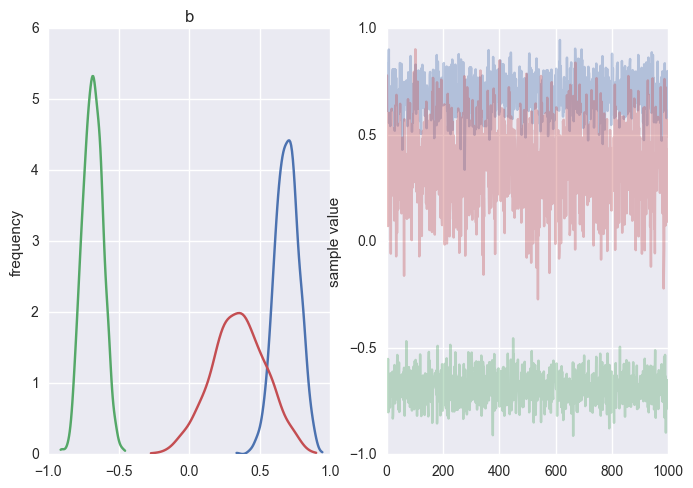

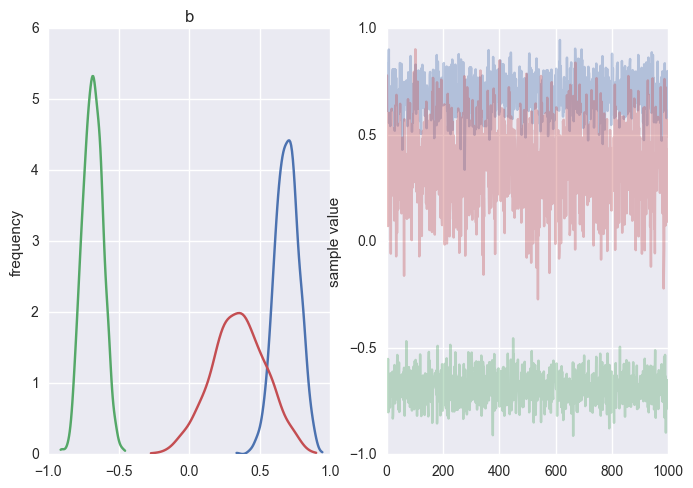

In [7]:
contextual_effect_fit.plot('b')

However we choose to visualise or summarise, the estimated mean value of $\beta_2$ (positive, non-zero) suggests that counties that have a relatively low proportion of houses with no basement tend to have higher prevailing levels of radon. We did not postulate a mechanism for this before modelling, but it may be that the feasbility of constructing a basement is related to the soil type, which is also related to the uranium level and so is associated with the prevailing log(radon) level for that county.